In [73]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import warnings
warnings.simplefilter(action="ignore")

In [74]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [75]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [76]:
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["date"] = price["date"].shift(-60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()
factors_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.10it/s]


ticker,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
0,2011-03-21,9.795083,9.2380,15.129165,NaN,21.661630,0.344631,2.175333
1,2011-03-22,9.748090,9.1295,15.097682,NaN,21.748084,0.342109,2.006000
2,2011-03-23,9.780623,9.1070,15.051457,NaN,21.571333,0.343944,1.703267
3,2011-03-24,9.804421,9.0545,14.965003,NaN,21.525224,0.342568,1.760667
4,2011-03-25,9.798999,9.1685,15.016975,NaN,21.494484,0.342568,1.848667
...,...,...,...,...,...,...,...,...
3458,2024-12-16,227.948911,191.6000,163.403647,560.900733,434.396724,115.992004,238.250000
3459,2024-12-17,226.220814,193.8800,161.665629,563.958284,432.640255,116.251986,250.000000
3460,2024-12-18,227.119824,193.9600,162.105128,562.879148,428.308963,120.861668,254.270000
3461,2024-12-19,226.120924,192.5300,161.306039,567.855163,431.243064,123.501486,257.020000


In [77]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = factors_df.merge(price[["date","ticker","adjclose"]],on="date",how="left")
        price["year"] = price["date"].dt.year
        price["quarter"] = price["date"].dt.quarter
        price["y"] = price["adjclose"].shift(-60)
        training_data = price[(price["year"]>=2013) & (price["year"] < 2020)].dropna(subset=factors).dropna()
        sim = price[price["year"]>=2019].dropna(subset=factors)
        model = XGBRegressor()
        model.fit(training_data[factors],training_data["y"])
        sim["prediction"] = model.predict(sim[factors])
        sim = sim.merge(macro,on="date",how="left")
        sim = CAPM.apply(sim)
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:09<00:56,  7.74it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:12<00:55,  7.63it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:25<00:00,  5.89it/s]

'date'


In [78]:
simulation = pd.concat(prices).merge(index[["ticker","GICS Sector"]],on="ticker",how="left")
simulation = simulation[(simulation["year"]>=2020)].dropna(subset="factor")

In [79]:
tickers = list(simulation[simulation["year"]==2020]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

In [105]:
simulation["rank"] = simulation.groupby(["date","GICS Sector"])["factor"].rank(method="dense",ascending=False).astype(int)

In [128]:
simulation["exposure"] = [1 if x <= simulation["rank"].max()*0.1 else -1 if x >= simulation["rank"].max() * 0.70 else 1.0/6.0 for x in simulation["rank"]]

In [129]:
simulation["projected"] = simulation["factor"] * simulation["exposure"]

In [130]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[["year","quarter","GICS Sector","ticker","projected","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"GICS Sector":"first","projected":"first","exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades = trades.sort_values("projected",ascending=False).groupby(["year","quarter","GICS Sector"]).first().reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"]
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [131]:
trades.iloc[-505:].to_csv("current.csv")

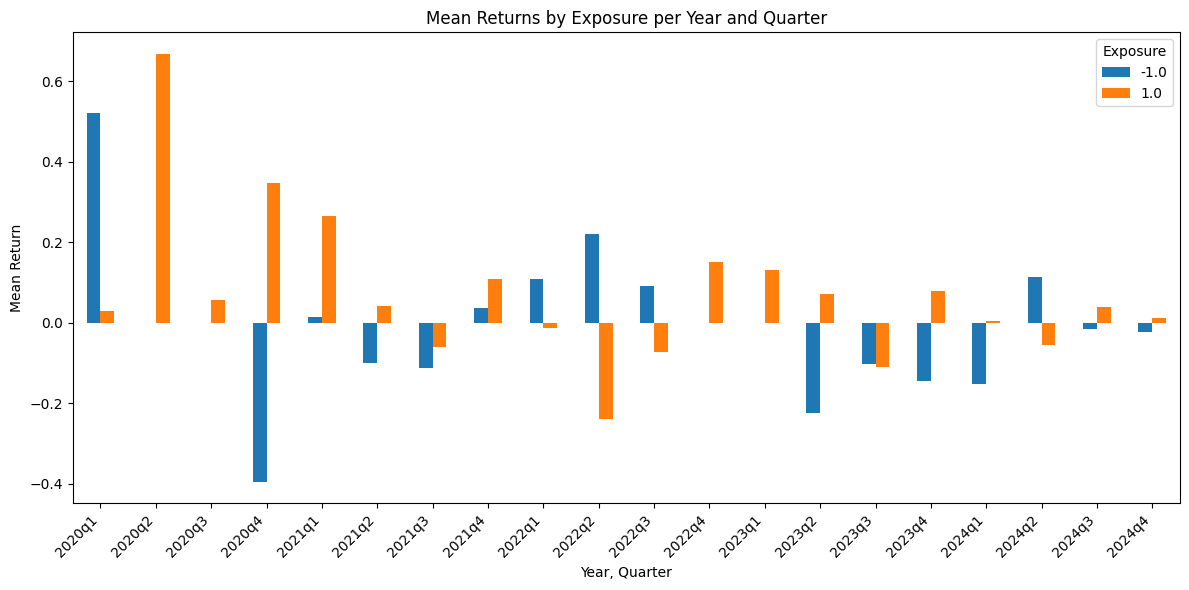

In [132]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


In [133]:
macro["year"] = [x.year for x in macro["date"]]
macro["quarter"] = [x.quarter for x in macro["date"]]
benchmark = macro.drop(["date","realtime_start","realtime_end"],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = benchmark["sp500"] / benchmark["sp500"].iloc[0] - 1
benchmark["rf"] = benchmark["rf"] / benchmark["rf"].iloc[0] - 1
benchmark["sp500_prediction"] = benchmark["sp500_prediction"] / benchmark["sp500_prediction"].iloc[0] - 1

In [134]:
benchmark

,year,quarter,sp500,sp500_prediction,rf
0,2019,1,0.000000,0.000000,0.000000
1,2019,2,0.059288,0.026727,-0.118382
2,2019,3,0.087044,0.066649,-0.322276
3,2019,4,0.132948,0.064636,-0.345658
4,2020,1,0.123067,-0.021868,-0.485479
5,2020,2,0.077428,0.063248,-0.740810
6,2020,3,0.220077,-0.037248,-0.754754
7,2020,4,0.306320,-0.048885,-0.684314
8,2021,1,0.420691,-0.069597,-0.496447
9,2021,2,0.537530,-0.136081,-0.401146


In [135]:
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

<Axes: title={'center': 'Mean Returns by Exposure per Year and Quarter'}, xlabel='Year-Quarter'>

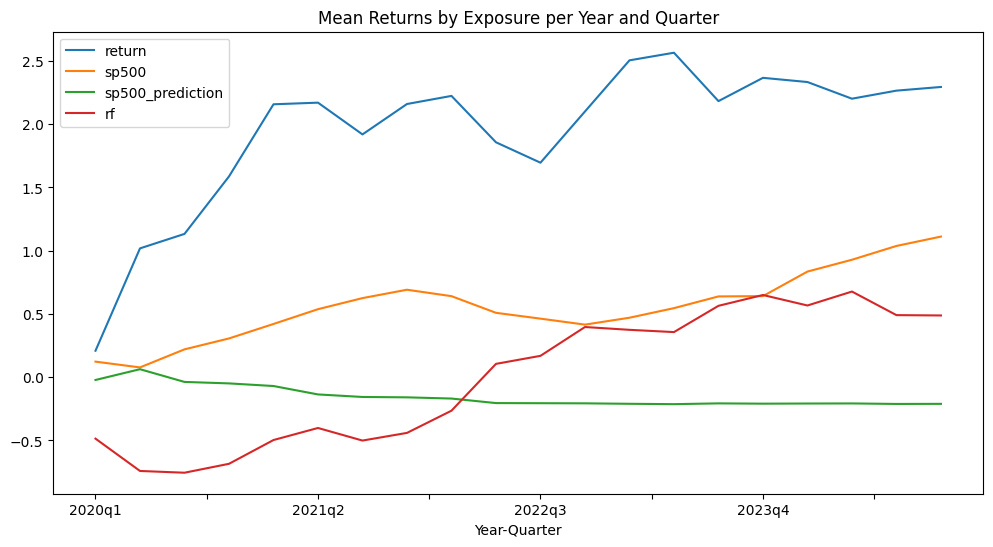

In [136]:
portfolio.drop(["year","quarter"],axis=1,inplace=True)
portfolio.set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

In [137]:
trades.groupby(["year","quarter","GICS Sector"]).agg({"return":"mean"}).tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples       -0.344336
             Energy                 -0.059165
             Financials             -0.072866
             Health Care            -0.157297
             Industrials            -0.060503
             Information Technology  0.234292
             Materials               0.130992
             Real Estate             0.191618
             Utilities               0.218081
     4       Communication Services -0.075980
             Consumer Discretionary  0.156203
             Consumer Staples       -0.015895
             Energy                  0.038117
             Financials              0.019491
             Health Care             0.003251
             Industrials             0.016064
             Information Technology -0.023358
             Materials               0.091603
             Real Estate             0.032003
             Utilities              -0.143775

In [138]:
sim

,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,ticker,adjclose,year,quarter,y,realtime_start,realtime_end,rf,factor,risk,sigma
0,2019-01-02,54.248610,95.4710,58.640488,158.248021,105.831965,6.918763,18.788667,ZBH,95.047196,2019,1,118.893931,2024-10-13,2024-10-13,0.0266,NaN,NaN,NaN
1,2019-01-03,53.368221,94.4825,58.180160,156.733782,105.212681,6.685157,17.463333,ZBH,93.328021,2019,1,118.949794,2024-10-13,2024-10-13,0.0256,NaN,NaN,NaN
2,2019-01-04,53.244491,93.2210,57.586815,156.654085,104.011644,6.583836,16.704000,ZBH,96.515466,2019,1,118.707723,2024-10-13,2024-10-13,0.0267,NaN,NaN,NaN
3,2019-01-07,53.982114,93.5160,57.051261,157.301622,105.334661,6.578139,17.520000,ZBH,96.552637,2019,1,117.758061,2024-10-13,2024-10-13,0.0270,NaN,NaN,NaN
4,2019-01-08,51.481333,87.7625,54.410354,150.806330,99.610971,6.086401,17.125333,ZBH,94.387405,2019,1,117.832544,2024-10-13,2024-10-13,0.0273,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2024-12-16,227.948911,191.6000,163.403647,560.900733,434.396724,115.992004,238.250000,ZBH,106.850000,2024,4,NaN,NaN,NaN,NaN,NaN,10.753248,7.695921
1500,2024-12-17,226.220814,193.8800,161.665629,563.958284,432.640255,116.251986,250.000000,ZBH,108.060000,2024,4,NaN,NaN,NaN,NaN,NaN,10.672978,7.706249
1501,2024-12-18,227.119824,193.9600,162.105128,562.879148,428.308963,120.861668,254.270000,ZBH,105.860000,2024,4,NaN,NaN,NaN,NaN,NaN,10.671007,7.725857
1502,2024-12-19,226.120924,192.5300,161.306039,567.855163,431.243064,123.501486,257.020000,ZBH,105.810000,2024,4,NaN,NaN,NaN,NaN,NaN,10.635032,7.745782
